# 평가 조건
1. 데이터의 전처리 및 구성과정이 체계적으로 진행되었는가?
 - 특수문자 제거, 토크나이저 생성, 패딩 처리의 작업들이 빠짐없이 진행되었는가?
2. 가사 텍스트 생성 모델이 정상적으로 동작하는가?
 - 텍스트 제너레이션 결과로 생성된 문장이 해석 가능한 문장인가?
3. 텍스트 생성모델이 안정적으로 학습되었는가?
 - 텍스트 생성모델의 validation loss가 2.2 이하로 낮아졌는가?

# 1. 모듈 임포트 및 데이터 불러오기

In [1]:
import os, re
import glob
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from collections import OrderedDict

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*' #os.getenv(x)함수는 환경 변수x의 값을 포함하는 문자열 변수를 반환합니다. txt_file_path 에 "/root/aiffel/lyricist/data/lyrics/*" 저장
#*는 해당 파일 안에 있는 모든 것을 불러오겠다는 의미

txt_list = glob.glob(txt_file_path) #txt_file_path 경로에 있는 모든 파일명을 리스트 형식으로 txt_list 에 할당

raw_corpus = [] 

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines() #read() : 파일 전체의 내용을 하나의 문자열로 읽어온다. , splitlines()  : 여러라인으로 구분되어 있는 문자열을 한라인씩 분리하여 리스트로 반환
        raw_corpus.extend(raw) # extend() : 리스트함수로 추가적인 내용을 연장 한다.

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ['', '', '[Spoken Intro:]']


In [2]:
len(txt_list)

49

In [3]:
txt_list[:2]

['/aiffel/aiffel/lyricist/data/lyrics/michael-jackson.txt',
 '/aiffel/aiffel/lyricist/data/lyrics/blink-182.txt']

- 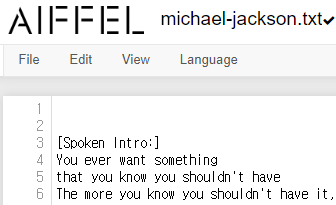
- 첫 파일을 열어보면 공백 2줄에 이어 가사가 시작됨을 알 수 있음
- f.read().splitlines()는 한 라인에 있는 가사를 하나의 문장으로 구분하여 불러옴
- 또한 파일은 총 49개이지만 그 안에 있는 가사를 한줄씩 데이터화 했을 경우 총 187,088개의 데이터가 존재하는것을 알 수 있음

# 2. 데이터 전처리
- 모든 실험에서 데이터의 전처리는 중요한 과정이지만, 특히 NLP 태스크에서는 더욱 중요함
- 전처리의 여부, 진행과정에 따라 결과가 천차만별로 달라질 수 있기 때문임

In [4]:
#단어 15개가 넘는 문장 갯수 확인

c = 0
for i in raw_corpus:
    if len(i.split()) > 15:
        c += 1
print(c)

7396


In [5]:
for i in range(len(raw_corpus[:10])):
    print("sentence{}:\n {}".format(i+1,raw_corpus[i]))

sentence1:
 
sentence2:
 
sentence3:
 [Spoken Intro:]
sentence4:
 You ever want something 
sentence5:
 that you know you shouldn't have 
sentence6:
 The more you know you shouldn't have it, 
sentence7:
 The more you want it 
sentence8:
 And then one day you get it, 
sentence9:
 It's so good too 
sentence10:
 But it's just like my girl 


- 1, 2번 문장은 길이가 0(공백)이기 때문에 제거를 해줘야 할 것으로 생각됨
- 3번은 특수문자가 들어가 있으며, 필요없는 문장으로 판단되어 제거해줘야 할 것으로 생각됨
- 또한 문자가 아닌 특수문자 같은 것들과 불필요한 공백들도 제거해줘야함
- 그리고 제거된 문장에 모델의 input값에 맞게 시작위치와 끝위치를 나타내는 문자를 삽입해줌
- 추가로 지나치게 긴 문장은 다른 데이터들이 과도한 Padding을 갖게 하므로 제거(단어의 수가 15개가 넘어가는것을 제거)

In [6]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() #소문자로 바꾸고, 양쪽 공백을 지움
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) #특수문자 양쪽에 공백 추가
    sentence = re.sub(r'[" "]+', " ", sentence) #여러개의 공백은 하나의 공백으로 교체
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) #-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 교체
    sentence = sentence.strip() #양쪽 공백 제거
    sentence = '<start> ' + sentence + ' <end>' #문장 시작에는 <start>, 끝에는 <end>를 추가
    return sentence

In [7]:
corpus = []

for sentence in raw_corpus:
    
    if len(sentence) == 0 : continue #공백인 문장 제거
    if len(sentence.split()) > 15 : continue #단어가 15개 이상인 문장 제거
    if "Intro" in sentence : continue #분석에 중요하지 않은 문장 제거

    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
    
# corpus = list(OrderedDict.fromkeys(corpus)) #순서를 유지하되 중복된 노래 가사 제거

print(len(corpus))

168558


## 토큰화

In [8]:
def tokenize(corpus):
    # 사전에 없는 단어는 '<unk>'처리
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000, #사전의 전체 단어 갯수
        filters=' ', #별도로 전처리 로직 추가 가능
        oov_token="<unk>" #사전에 없는 단어 처리
    )
    # tokenizer.fit_on_texts(texts): 문자 데이터를 입력받아 리스트의 형태로 변환하는 메서드
    tokenizer.fit_on_texts(corpus)
    
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    # tokenizer.texts_to_sequences(texts): 텍스트 안의 단어들을 숫자의 시퀀스 형태로 변환하는 메서드
    tensor = tokenizer.texts_to_sequences(corpus)   
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post',truncating='post', maxlen=15)  #maxlen는 텐서 한 문장의 길이를 나타냄
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2    7  159 ...    0    0    0]
 [   2   17    7 ...    0    0    0]
 [   2    6   99 ...    0    0    0]
 ...
 [   2  308    1 ...    0    0    0]
 [   2  726    5 ... 2305   19 1148]
 [   2  726    5 ... 2305   19 1148]] <keras_preprocessing.text.Tokenizer object at 0x7fa540726f40>


In [9]:
#단어 사전 확인

for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : i
6 : the
7 : you
8 : and
9 : a
10 : to


In [10]:
src_input = tensor[:, :-1]  #행은 다 들어가고 열에서 마지막것만 제거
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]   #행은 다 들어가고 열에서 첫번째것만 제거

print(src_input[0])#마지막 열의 토큰만 없음(end)
print(tgt_input[0])#첫번째 열의 토큰만 없음(start)

[  2   7 159  65 195   3   0   0   0   0   0   0   0   0]
[  7 159  65 195   3   0   0   0   0   0   0   0   0   0]


# 3. 평가 데이터셋 분리

In [11]:
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size=0.2, shuffle=True, random_state=1234)

In [12]:
BUFFER_SIZE = len(enc_train)
BATCH_SIZE = 512
steps_per_epoch = len(enc_train) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1 #10000+ unk 1로 총 10001개의 사전 

In [13]:
#데이터셋 만들기

train_dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train)).shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

val_dataset  = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))
val_dataset  = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [14]:
print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape)

Source Train: (134846, 14)
Target Train: (134846, 14)


# 4. 모델링

In [15]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        # Embedding 레이어, 2개의 LSTM 레이어, 1개의 Dense 레이어로 구성
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size) 
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out

embedding_size =1024
hidden_size = 2048
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size) # tokenizer.num_words에 +1인 이유는 문장에 없는 pad가 사용되었기 때문

In [16]:
for src_sample, tgt_sample in train_dataset.take(1): break
model(src_sample)

<tf.Tensor: shape=(512, 14, 12001), dtype=float32, numpy=
array([[[ 5.0981366e-04,  2.9586579e-04, -2.4138368e-04, ...,
         -1.2676860e-04, -5.2766118e-04, -1.5074124e-04],
        [ 4.7207330e-05,  6.9492968e-04, -1.8736637e-04, ...,
         -2.6227708e-04, -8.9079671e-04, -5.6201225e-04],
        [-3.6083005e-04,  1.0014438e-03, -5.6520355e-04, ...,
         -3.9616771e-04, -8.9518086e-04, -1.2011711e-03],
        ...,
        [ 1.3363869e-03, -3.8774556e-04,  2.7741288e-04, ...,
         -1.9959873e-03, -1.6162307e-03, -1.8367515e-03],
        [ 2.0307701e-03, -5.2778830e-04,  9.4975589e-04, ...,
         -2.3666569e-03, -1.7837470e-03, -1.7243606e-03],
        [ 2.6648783e-03, -5.1660329e-04,  1.6408662e-03, ...,
         -2.7808286e-03, -1.9759783e-03, -1.6376951e-03]],

       [[ 5.0981366e-04,  2.9586579e-04, -2.4138368e-04, ...,
         -1.2676860e-04, -5.2766118e-04, -1.5074124e-04],
        [ 1.0269537e-03,  1.7662288e-04, -4.0670243e-04, ...,
         -3.0941493e-04, 

In [17]:
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  12289024  
_________________________________________________________________
lstm (LSTM)                  multiple                  25174016  
_________________________________________________________________
lstm_1 (LSTM)                multiple                  33562624  
_________________________________________________________________
dense (Dense)                multiple                  24590049  
Total params: 95,615,713
Trainable params: 95,615,713
Non-trainable params: 0
_________________________________________________________________


In [18]:
optimizer = tf.keras.optimizers.Adam() # Adam은 현재 가장 많이 사용하는 옵티마이저
loss = tf.keras.losses.SparseCategoricalCrossentropy( # 훈련 데이터의 라벨이 정수의 형태로 제공될 때 사용하는 손실함수
    from_logits=True, # 기본값은 False이다. 모델에 의해 생성된 출력 값이 정규화되지 않았음을 손실 함수에 알려준다. 즉 softmax함수가 적용되지 않았다는걸 의미한다. 
    reduction='none'  # 기본값은 SUM이다. 각자 나오는 값의 반환 원할 때 None을 사용한다.
)

model.compile(loss=loss, optimizer=optimizer)
history = model.fit(train_dataset, epochs=10, batch_size=512,
          validation_data=val_dataset,validation_batch_size=512)

Epoch 1/10
263/263 [==============================] - 276s 1s/step - loss: 3.5463 - val_loss: 3.1107
Epoch 2/10
263/263 [==============================] - 274s 1s/step - loss: 2.9408 - val_loss: 2.8622
Epoch 3/10
263/263 [==============================] - 274s 1s/step - loss: 2.6699 - val_loss: 2.6942
Epoch 4/10
263/263 [==============================] - 274s 1s/step - loss: 2.4165 - val_loss: 2.5625
Epoch 5/10
263/263 [==============================] - 274s 1s/step - loss: 2.1671 - val_loss: 2.4557
Epoch 6/10
263/263 [==============================] - 275s 1s/step - loss: 1.9230 - val_loss: 2.3695
Epoch 7/10
263/263 [==============================] - 275s 1s/step - loss: 1.6902 - val_loss: 2.3055
Epoch 8/10
263/263 [==============================] - 275s 1s/step - loss: 1.4810 - val_loss: 2.2653
Epoch 9/10
263/263 [==============================] - 275s 1s/step - loss: 1.3055 - val_loss: 2.2488
Epoch 10/10
263/263 [==============================] - 275s 1s/step - loss: 1.1703 - val_lo

In [19]:
#문장생성 함수 정의
#모델에게 시작 문장을 전달하면 모델이 시작 문장을 바탕으로 작문을 진행
def generate_text(model, tokenizer, init_sentence="<start>", max_len=15): #시작 문자열을 init_sentence 로 받으며 디폴트값은 <start> 를 받는다
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence]) #텍스트 안의 단어들을 숫자의 시퀀스의 형태로 변환
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다 (도달 하지 못하였으면 while 루프를 돌면서 다음 단어를 예측)
    while True: #루프를 돌면서 init_sentence에 단어를 하나씩 생성성
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4 
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated #최종적으로 모델이 생성한 문장을 반환

In [21]:
generate_text(model, tokenizer, init_sentence="<start> i")

'<start> i m the worlds greatest i m that little bit of hope <end> '

- 번역 : 나는 세상에서 가장 작은 희망입니다

In [22]:
generate_text(model, tokenizer, init_sentence="<start> we")

'<start> we re gonna have a good time <end> '

- 번역 : 우리는 좋은 시간을 보낼 것입니다

In [26]:
generate_text(model, tokenizer, init_sentence="<start> love")

'<start> love is a beautiful thing <end> '

- 번역 : 사랑은 아름다운 것입니다

# 전체회고
- 시도해본 방법
1. layer 추가
2. dropout 추가
3. 하이퍼파라미터 변경
4. 데이터 전처리
 - 사전 크기 변경
 - 중복된 노래 가사 제거
 - 15개 단어 이상이 존재하는 가사 제거
 - intro 등 불필요한 단어가 존재하는 가사 제거
 - model.fit 파라미터 추가
 - pad_sequences 패딩 위치 변경
 
- 문장 생성 NLP는 처음 다뤄 보았음
- 생각보다 loss 값이 안떨어져서 시간이 오래 걸렸음
- loss값을 보면 결국 과적합이 된것으로 판단됨
- 과적합을 방지하기위해 위에서 제시한 다양한 방법들과 이전 기수들것들을 참고하여 시도하였지만, 결국 2.2 이하로는 떨어뜨리지 못하였음
- RNN이나 LSTM을 직접 만들어서 쓴것은 처음인데, 아직 부족한 점과 공부해야할 점이 많다고 생각됨